In [1]:
import xml.etree.ElementTree as ET
import os
import cv2
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle as pkl

In [2]:
directory = './DETRAC-Train-Annotations-XML/DETRAC-Train-Annotations-XML/'
directory_list = []

In [3]:
camera_list = sorted(os.listdir(directory))

In [4]:
print(sorted(camera_list))

['MVI_20011.xml', 'MVI_20012.xml', 'MVI_20032.xml', 'MVI_20033.xml', 'MVI_20034.xml', 'MVI_20035.xml', 'MVI_20051.xml', 'MVI_20052.xml', 'MVI_20061.xml', 'MVI_20062.xml', 'MVI_20063.xml', 'MVI_20064.xml', 'MVI_20065.xml', 'MVI_39761.xml', 'MVI_39771.xml', 'MVI_39781.xml', 'MVI_39801.xml', 'MVI_39811.xml', 'MVI_39821.xml', 'MVI_39851.xml', 'MVI_39861.xml', 'MVI_39931.xml', 'MVI_40131.xml', 'MVI_40141.xml', 'MVI_40152.xml', 'MVI_40161.xml', 'MVI_40162.xml', 'MVI_40171.xml', 'MVI_40172.xml', 'MVI_40181.xml', 'MVI_40191.xml', 'MVI_40192.xml', 'MVI_40201.xml', 'MVI_40204.xml', 'MVI_40211.xml', 'MVI_40212.xml', 'MVI_40213.xml', 'MVI_40241.xml', 'MVI_40243.xml', 'MVI_40244.xml', 'MVI_40732.xml', 'MVI_40751.xml', 'MVI_40752.xml', 'MVI_40871.xml', 'MVI_40962.xml', 'MVI_40963.xml', 'MVI_40981.xml', 'MVI_40991.xml', 'MVI_40992.xml', 'MVI_41063.xml', 'MVI_41073.xml', 'MVI_63521.xml', 'MVI_63525.xml', 'MVI_63544.xml', 'MVI_63552.xml', 'MVI_63553.xml', 'MVI_63554.xml', 'MVI_63561.xml', 'MVI_63562.xm

In [5]:
def get_info(file_name):
    file_info = {'frame_num': [], 'boxes':[]}
    ignore_area = {'file_name':file_name.split('.')[0], 'region':[]}
    doc = ET.parse(directory + file_name)
    root = doc.getroot()
    ignore_region = root.findall("ignored_region")
    for ign in ignore_region:
        for box in ign.findall('box'):
            ignore_area['region'].append({
                'x':box.attrib['left'],
                'y':box.attrib['top'],
                'w':box.attrib['width'],
                'h':box.attrib['height']
            })
    frame_list = []
    frames = root.findall("frame")
    for frame in frames:
        file_info['frame_num'].append(frame.attrib['num'])
        for target in frame.findall("target_list"):
            box_list = []
            for u in target.findall("target"):
                box = u.find('box').attrib
                box_list.append({
                    'x':box['left'],
                    'y':box['top'],
                    'w':box['width'],
                    'h':box['height'],
                    'label':1
                })
            file_info['boxes'].append(box_list)
    return (ignore_area, file_info)

In [6]:

k = get_info(camera_list[0])
print(k[0]['file_name'])

MVI_20011


In [7]:
print(k[1]['boxes'][0])

[{'w': '160.05', 'y': '378.8', 'label': 1, 'h': '162.2', 'x': '592.75'}, {'w': '47.2', 'y': '120.98', 'label': 1, 'h': '43.06', 'x': '557.65'}, {'w': '35.25', 'y': '88.27', 'label': 1, 'h': '30.08', 'x': '545.2'}, {'w': '28.0', 'y': '67.5', 'label': 1, 'h': '25.925', 'x': '508.35'}, {'w': '29.55', 'y': '70.095', 'label': 1, 'h': '19.695', 'x': '553'}, {'w': '52.4', 'y': '114.23', 'label': 1, 'h': '39.95', 'x': '731.1'}, {'w': '58.85', 'y': '250.12', 'label': 1, 'h': '107.99', 'x': '902.15'}]


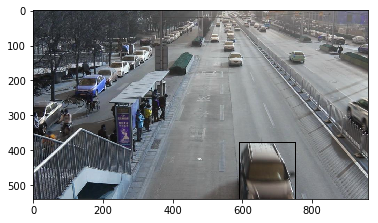

In [8]:
img_directory = 'DETRAC-train-data/Insight-MVT_Annotation_Train/MVI_20011/img00001.jpg'
img = cv2.imread(img_directory)
cv2.rectangle(img, (592,378), (592 + 160, 378 + 162), 2, 2)
plt.imshow(img)

In [9]:

img_directory = './DETRAC-train-data/Insight-MVT_Annotation_Train/'

def delete_ignore_area(img, img_igarea):
    for box in img_igarea:
        x = int(float(box['x'])+1)
        y = int(float(box['y'])+1)
        w = int(float(box['w']))
        h = int(float(box['h']))
        img[x : x+w , y:y+h] = 0
    return img

def read_data(camera_angle):
    img_list = []
    box_value = []
    angle_number = [str(pixel_num).zfill(5)[-5:] for pixel_num in range(1, len(camera_angle[1]['frame_num'])+1)]
    for frame_num in angle_number:
        img_file_name = img_directory + camera_angle[0]['file_name'] + '/img' + frame_num + '.jpg'
        img = cv2.imread(img_file_name)
        img = delete_ignore_area(img, camera_angle[0]['region'])
        img_list.append(img)
    for step_box in camera_angle[1]['boxes']:
        num_box = []
        for box in step_box:
            x,y,w,h = float(box['x'])-1, float(box['y'])-1, float(box['w'])+1, float(box['h'])+1
            box = [x, y, x+w, y+h , 1, 1]
            num_box.append(box)
        box_value.append(num_box)
    img_list = np.array(img_list)
    box_value = np.array(box_value) 
    return img_list, box_value

In [10]:
img_list, box_value = read_data(k)
print(img_list.shape)
print(box_value.shape)


(664, 540, 960, 3)
(664,)


In [11]:
for i in range(len(box_value[-5])):
    x,y,w,h, _, _ = box_value[-5][i]
    cv2.rectangle(img_list[-5],(int(x),int(y)), (int(x + w), int(y+h)) ,2, 2)
print(x,y,w,h)

841.0 86.49 907.65 132.37


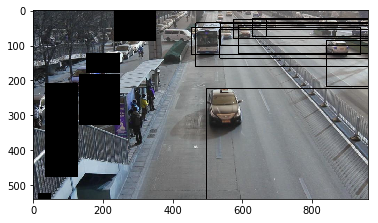

In [12]:
plt.imshow(cv2.rectangle(img_list[-5],(int(x),int(y)), (int(x + w), int(y+h)) ,2, 2))


In [13]:
camera_list = [get_info(camera) for camera in camera_list]

In [14]:

cnt = 0
for camera in camera_list:
    img, box = read_data(camera)
    print(camera[0]["file_name"])
    print(img.shape, box.shape)
    for i in range(len(img)):
        with open("./input/" + str(cnt + i) + '.pkl', 'wb') as fw:
            pkl.dump(img[i], fw)
    for i in range(len(img)):
        with open("./output/" + str(cnt + i) + '.pkl', 'wb') as fw:
            pkl.dump(box[i], fw)
    print(cnt,len(img))
    cnt += len(img)

MVI_20011
(664, 540, 960, 3) (664,)
0 664
MVI_20012
(936, 540, 960, 3) (936,)
664 936
MVI_20032
(437, 540, 960, 3) (437,)
1600 437
MVI_20033
(784, 540, 960, 3) (784,)
2037 784
MVI_20034
(800, 540, 960, 3) (800,)
2821 800
MVI_20035
(800, 540, 960, 3) (800,)
3621 800
MVI_20051
(906, 540, 960, 3) (906,)
4421 906
MVI_20052
(694, 540, 960, 3) (694,)
5327 694
MVI_20061
(800, 540, 960, 3) (800,)
6021 800
MVI_20062
(800, 540, 960, 3) (800,)
6821 800
MVI_20063
(800, 540, 960, 3) (800,)
7621 800
MVI_20064
(800, 540, 960, 3) (800,)
8421 800
MVI_20065
(1200, 540, 960, 3) (1200,)
9221 1200
MVI_39761
(1323, 540, 960, 3) (1323,)
10421 1323
MVI_39771
(570, 540, 960, 3) (570,)
11744 570
MVI_39781
(1861, 540, 960, 3) (1861,)
12314 1861
MVI_39801
(885, 540, 960, 3) (885,)
14175 885
MVI_39811
(500, 540, 960, 3) (500,)
15060 500
MVI_39821
(880, 540, 960, 3) (880,)
15560 880
MVI_39851
(1286, 540, 960, 3) (1286,)
16440 1286
MVI_39861
(745, 540, 960, 3) (745,)
17726 745
MVI_39931
(1082, 540, 960, 3) (1082,)
1

In [15]:
import os

In [ ]:
file = sorted(os.listdir('./output'))

In [ ]:
len(file)

In [ ]:
output_list = []
for i in range(len(file)):
    with open('./output/' + str(file[i]), 'rb') as f:
        output_list.append(pkl.load(f))

In [16]:
with open('./input/' + '1.pkl', 'rb') as f:
    inp = pkl.load(f)

In [17]:
print(inp.shape)

(540, 960, 3)


In [ ]:
stride_size = [20, 40, 60]

In [ ]:
x,y,w,h,_,_ = output_list[0][0]
x = int(x)
y = int(y)
w = int(w)
h = int(h)

In [ ]:
output_list[0]

In [ ]:
for i in range(len(output_list[1])):
    x,y,w,h, _, _ = output_list[1][i]
    cv2.rectangle(inp,(int(x),int(y)), (int(x + w), int(y+h)) ,2, 2)
print(x,y,w,h)

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(inp)

In [ ]:
print(img.shape)

In [ ]:
box_value = np.zeros((540//60, 960//60, 6), dtype = np.float32)
print(box_value[1])
for i in range(len(output_list[1])):
    x,y,w,h, _, _ = output_list[1][i]
    cent_x, cent_y = (x+w)/2, (y+h)/2
    print(cent_x, cent_y)
    print(cent_x//60, cent_y//60)

In [ ]:
print(box_value)